This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

### Processing words as a sequence: The sequence model approach

#### A first practical example

**Downloading the data**

In [24]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  29.1M      0  0:00:02  0:00:02 --:--:-- 29.1M


**Preparing the data**

In [18]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    # Check if the directory already exists before creating it
    if not os.path.exists(val_dir / category):
        os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 12800 files belonging to 2 classes.
Found 12200 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Preparing integer sequence datasets**

In [19]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [27]:
!pip install tensorflow



In [20]:
# Standard Python imports
import os
import re
from google.colab import files

# TensorFlow / Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer  # Updated location
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Embedding, LSTM, Dropout

# Scikit-learn
from sklearn.model_selection import train_test_split

# Dataset import
from tensorflow.keras.datasets import imdb


In [33]:
!pip install --upgrade tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 797.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is i

In [12]:
import tensorflow as tf
print(tf.__version__)


2.20.0


Consider the IMDB example from Chapter 11 (Section 11.3, chapter11_part02_sequence-
models.ipynb). Re-run the example modifying the following:
1) Cutoff reviews after 150 words
2) Restrict training samples to 100
3) Validate on 10,000 samples
4) Consider only the top 10,000 words

In [21]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Parameters
VOCAB_SIZE = 10000  # Top 10,000 words
MAX_REVIEW_LENGTH = 150  # Cutoff reviews after 150 words
TRAIN_SAMPLES = 100  # Restrict training samples to 100
VAL_SAMPLES = 10000  # Validate on 10,000 samples

# Load and prepare the data
(x_train_original, y_train_original), (x_test_original, y_test_original) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad sequences to MAX_REVIEW_LENGTH
x_train_padded = pad_sequences(x_train_original, maxlen=MAX_REVIEW_LENGTH)
x_test_padded = pad_sequences(x_test_original, maxlen=MAX_REVIEW_LENGTH)

# Combine all data for stratified splitting
x_all = np.concatenate((x_train_padded, x_test_padded), axis=0)
y_all = np.concatenate((y_train_original, y_test_original), axis=0)

# Create small training set and validation set
x_small_train, x_val, y_small_train, y_val = train_test_split(
    x_all, y_all,
    train_size=TRAIN_SAMPLES,
    test_size=VAL_SAMPLES,
    random_state=42,
    stratify=y_all
)

# Create final test set (6000 samples)
_, x_final_test, _, y_final_test = train_test_split(
    x_test_padded, y_test_original,
    test_size=6000,
    random_state=42,
    stratify=y_test_original
)

In [22]:
x_small_train.shape

(100, 150)

In [23]:
x_val.shape

(10000, 150)

In [24]:
x_final_test.shape


(6000, 150)

**Building the model 1**

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# -------------------------
# Define constants
VOCAB_SIZE = 10000       # Top 10,000 words in the vocabulary
MAX_REVIEW_LENGTH = 150  # Maximum length of input sequences

# -------------------------
# Define the sentiment analysis model
sentiment_classifier = Sequential([
    Embedding(
        input_dim=VOCAB_SIZE,  # Vocabulary size
        output_dim=8           # 8-dimensional embeddings
        # input_length is removed (deprecated)
    ),
    Flatten(),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
sentiment_classifier.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Explicitly build the model to display correct summary
sentiment_classifier.build(input_shape=(None, MAX_REVIEW_LENGTH))

# Display model summary
sentiment_classifier.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 150, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,201 (317.19 KB)

 Trainable params: 81,201 (317.19 KB)

 Non-trainable params: 0 (0.00 B)

Executing the model

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath="sentiment_classifier.h5",
    save_best_only=True,
    monitor="val_loss"
)

train_history = sentiment_classifier.fit(
    x_small_train, y_small_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_callback]
)


Epoch 1/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 915ms/step - accuracy: 0.4062 - loss: 0.6920

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.4543 - loss: 0.6937 - val_accuracy: 0.5110 - val_loss: 0.6928
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.7841 - loss: 0.6715 - val_accuracy: 0.5108 - val_loss: 0.6929
Epoch 3/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9688 - loss: 0.6526

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.9653 - loss: 0.6517 - val_accuracy: 0.5100 - val_loss: 0.6928
Epoch 4/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9688 - loss: 0.6369

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.9693 - loss: 0.6385 - val_accuracy: 0.5090 - val_loss: 0.6928
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.9693 - loss: 0.6244 - val_accuracy: 0.5097 - val_loss: 0.6928
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step - accuracy: 0.9755 - loss: 0.6103 - val_accuracy: 0.5105 - val_loss: 0.6928
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.9847 - loss: 0.5955 - val_accuracy: 0.5103 - val_loss: 0.6928
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.9847 - loss: 0.5833 - val_accuracy: 0.5100 - val_loss: 0.6928
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.9693 - loss: 0.5689 - val_accuracy: 0.5112 - val_loss: 0.6928
Epoch 10/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.5468

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.9908 - loss: 0.5518 - val_accuracy: 0.5116 - val_loss: 0.6928
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.9838 - loss: 0.5337 - val_accuracy: 0.5107 - val_loss: 0.6929
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 1.0000 - loss: 0.5211 - val_accuracy: 0.5112 - val_loss: 0.6929
Epoch 13/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 1.0000 - loss: 0.5057 - val_accuracy: 0.5106 - val_loss: 0.6931
Epoch 14/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 1.0000 - loss: 0.4906 - val_accuracy: 0.5077 - val_loss: 0.6932
Epoch 15/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 1.0000 - loss: 0.4677 - val_accuracy: 0.5071 - val_loss: 0.6933
Epoch 16/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 1.0000 - loss: 0.4490 - val_accuracy: 0.5073 - val_loss: 0.6934
Epoch 17/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 1.0000 - loss: 0.4291 - val_accuracy: 0.5078 - val_loss: 0.6

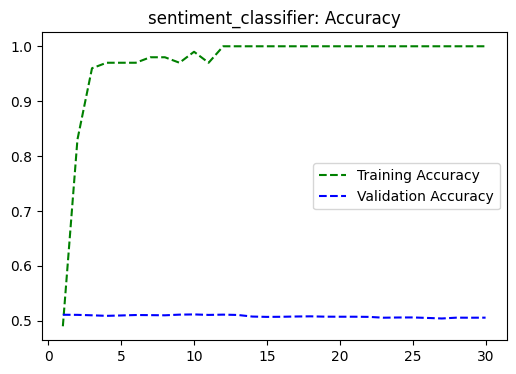

<Figure size 640x480 with 0 Axes>

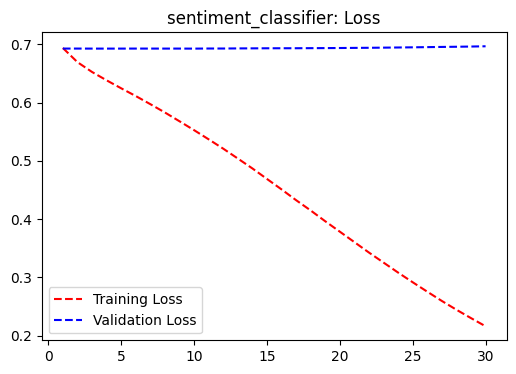

In [28]:
import matplotlib.pyplot as plt

train_accuracy = train_history.history['accuracy']
val_accuracy = train_history.history['val_accuracy']

train_loss = train_history.history["loss"]
val_loss = train_history.history["val_loss"]

epoch_range = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_accuracy, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epoch_range, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("sentiment_classifier: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epoch_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("sentiment_classifier: Loss")
plt.legend()
plt.show()

In [29]:
from tensorflow.keras.models import load_model

# Loading the saved model
loaded_model = load_model('sentiment_classifier.h5')

# Evaluating the model on the test data
evaluation_results = loaded_model.evaluate(x_final_test, y_final_test)

# Printing the results (Loss and Accuracy)
print(f'Loss: {evaluation_results[0]:.3f}')
print(f'Accuracy: {evaluation_results[1]:.3f}')

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5170 - loss: 0.6927
Loss: 0.693
Accuracy: 0.513


**Model 2: Baseline Model with Embedded Layer (Training Sample Size: 10,000)**

In [30]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Constants for data configuration
MAX_VOCAB_SIZE = 10000          # Consider only top 10,000 words
MAX_SEQUENCE_LENGTH = 150       # Truncate/pad reviews to 150 words

# Load and preprocess the IMDB dataset
(train_reviews, train_sentiments), (test_reviews, test_sentiments) = imdb.load_data(num_words=MAX_VOCAB_SIZE)

# Pad sequences to uniform length
padded_train_reviews = pad_sequences(train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all data for stratified splitting (for training and validation)
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_sentiments = np.concatenate((train_sentiments, test_sentiments), axis=0)

# Split 10,000 training and 10,000 validation samples
train_reviews_final, val_reviews, train_sentiments_final, val_sentiments = train_test_split(
    all_reviews,
    all_sentiments,
    train_size=10000,
    test_size=10000,
    random_state=42,
    stratify=all_sentiments
)

# From the original test set, extract 6,000 test samples
_, test_reviews_final, _, test_sentiments_final = train_test_split(
    padded_test_reviews,
    test_sentiments,
    test_size=6000,
    random_state=42,
    stratify=test_sentiments
)


In [31]:
train_reviews_final.shape

(10000, 150)

In [32]:
val_reviews.shape

(10000, 150)

In [33]:
test_reviews_final.shape

(6000, 150)

In [35]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

# -------------------------
# Constants for data configuration
MAX_VOCAB_SIZE = 10000      # Top 10,000 most frequent words
MAX_SEQUENCE_LENGTH = 150   # Maximum words in a review
EMBEDDING_DIM = 8           # Embedding dimensions

# -------------------------
# Load IMDB dataset (pre-tokenized as integer word indices)
(train_reviews, train_sentiments), (test_reviews, test_sentiments) = imdb.load_data(num_words=MAX_VOCAB_SIZE)

# Pad sequences to a fixed length
padded_train_reviews = pad_sequences(train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine full dataset for custom split
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_sentiments = np.concatenate((train_sentiments, test_sentiments), axis=0)

# Create 10,000 training and 10,000 validation samples
train_reviews_final, val_reviews, train_sentiments_final, val_sentiments = train_test_split(
    all_reviews, all_sentiments,
    train_size=10000,
    test_size=10000,
    random_state=42,
    stratify=all_sentiments
)

# Select 6,000 test samples from the original test set
_, test_reviews_final, _, test_sentiments_final = train_test_split(
    padded_test_reviews, test_sentiments,
    test_size=6000,
    random_state=42,
    stratify=test_sentiments
)

# -------------------------
# Define a simple Sequential model for sentiment classification
sentiment_analysis_model = Sequential([
    Embedding(
        input_dim=MAX_VOCAB_SIZE,  # Vocabulary size
        output_dim=EMBEDDING_DIM    # Embedding dimensions
        # input_length removed (deprecated)
    ),
    Flatten(),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
sentiment_analysis_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Explicitly build the model to show correct parameter counts
sentiment_analysis_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Display model summary
sentiment_analysis_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 150, 8)         │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         1,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,201 (317.19 KB)

 Trainable params: 81,201 (317.19 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Setup model checkpoint to save the best version during training
model_checkpoint = ModelCheckpoint(
    filepath="best_sentiment_model.h5",  # More descriptive filename
    save_best_only=True,                # Only keep the best model
    monitor="val_loss",                 # Monitor validation loss

)

# Train the sentiment analysis model
train_history1 = sentiment_analysis_model.fit(
    x_small_train, y_small_train,
    epochs=30,                         # Number of training epochs
    batch_size=32,                     # Batch size
    validation_data=(x_val, y_val),  # Validation data
    callbacks=[model_checkpoint],      # Include our checkpoint callback

)

Epoch 1/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 918ms/step - accuracy: 0.5312 - loss: 0.6957

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.4870 - loss: 0.6959 - val_accuracy: 0.5004 - val_loss: 0.6932
Epoch 2/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8438 - loss: 0.6756

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.8739 - loss: 0.6732 - val_accuracy: 0.5018 - val_loss: 0.6931
Epoch 3/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9688 - loss: 0.6570

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.9724 - loss: 0.6553 - val_accuracy: 0.5074 - val_loss: 0.6931
Epoch 4/30
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.6398

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.9816 - loss: 0.6420 - val_accuracy: 0.5094 - val_loss: 0.6930
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - accuracy: 0.9908 - loss: 0.6282 - val_accuracy: 0.5072 - val_loss: 0.6931
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 1.0000 - loss: 0.6144 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.9908 - loss: 0.6017 - val_accuracy: 0.5028 - val_loss: 0.6932
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.9908 - loss: 0.5876 - val_accuracy: 0.5022 - val_loss: 0.6932
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 1.0000 - loss: 0.5739 - val_accuracy: 0.5041 - val_loss: 0.6933
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 1.0000 - loss: 0.5581 - val_accuracy: 0.5027 - val_loss: 0.6933
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 1.0000 - loss: 0.5415 - val_accuracy: 0.5009 - val_loss: 0.6934
E

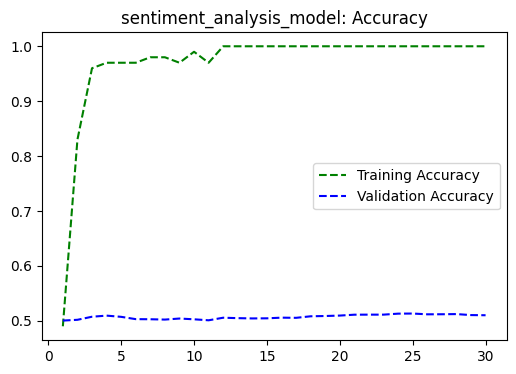

<Figure size 640x480 with 0 Axes>

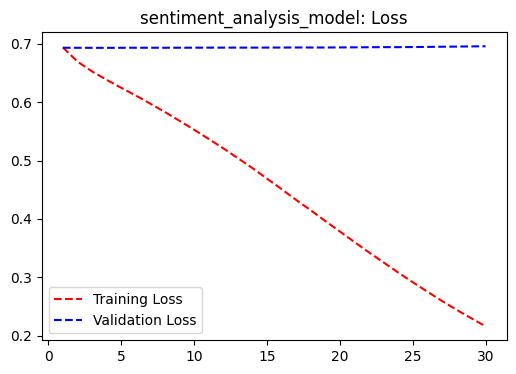

In [37]:
import matplotlib.pyplot as plt

val_accuracy = train_history1.history['val_accuracy']

training_loss = train_history1.history['loss']
val_loss = train_history1.history['val_loss']

epochs_range = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_accuracy, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("sentiment_analysis_model: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("sentiment_analysis_model: Loss")
plt.legend()
plt.show()

In [38]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_sentiment_model.h5')

evaluation_results = loaded_model.evaluate(test_reviews_final, test_sentiments_final)
print(f'Loss: {evaluation_results[0]:.3f}')
print(f'Accuracy: {evaluation_results[1]:.3f}')

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5010 - loss: 0.6931
Loss: 0.693
Accuracy: 0.502


**Model 3: Baseline Model with Embedded Layer (Training Sample Size: 16,000)**



In [39]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

# Constants
VOCABULARY_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Load IMDB dataset
(raw_train_reviews, raw_train_labels), (raw_test_reviews, raw_test_labels) = imdb.load_data(num_words=VOCABULARY_SIZE)

# Pad sequences to ensure equal length
padded_train_reviews = pad_sequences(raw_train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(raw_test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all data for stratified train/validation split
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_labels = np.concatenate((raw_train_labels, raw_test_labels), axis=0)

# Create 16,000 training samples and 10,000 validation samples
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    all_reviews,
    all_labels,
    train_size=16000,
    test_size=10000,
    random_state=42,
    stratify=all_labels
)

# Create final test set of 6,000 samples from original test set
_, final_test_reviews, _, final_test_labels = train_test_split(
    padded_test_reviews,
    raw_test_labels,
    test_size=6000,
    random_state=42,
    stratify=raw_test_labels
)


In [40]:
train_reviews.shape

(16000, 150)

In [41]:
val_reviews.shape

(10000, 150)

In [42]:
final_test_reviews.shape

(6000, 150)

Building model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

# -------------------------
# Define constants
VOCABULARY_SIZE = 10000       # Top 10,000 words
MAX_SEQUENCE_LENGTH = 150     # Maximum length of input sequences
EMBEDDING_DIM = 8             # Embedding dimensions

# -------------------------
# Define the model architecture
sentiment_analysis_model = Sequential([
    Embedding(
        input_dim=VOCABULARY_SIZE,  # Vocabulary size
        output_dim=EMBEDDING_DIM,    # Embedding dimensions
        name='word_embedding_layer'
        # input_length removed (deprecated)
    ),
    Flatten(name='flatten_layer'),
    Dense(1, activation='sigmoid', name='output_layer')
])

# Compile the model
sentiment_analysis_model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Explicitly build the model to display correct summary
sentiment_analysis_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

# Display model summary
sentiment_analysis_model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ word_embedding_layer            │ (None, 150, 8)         │        80,000 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │         1,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,201 (317.19 KB)

 Trainable params: 81,201 (317.19 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define model checkpoint callback to save the best model
best_model_checkpoint = ModelCheckpoint(
    filepath="best_sentiment_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"   # Explicitly set to minimize validation loss
)

# Train the model with checkpointing
model_training_history = sentiment_analysis_model.fit(
    x=train_reviews,  # Using our renamed variables from earlier
    y=train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(val_reviews, val_labels),  # Using our renamed validation set
    callbacks=[best_model_checkpoint],

)

Epoch 1/30
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5890 - loss: 0.6727

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5901 - loss: 0.6720 - val_accuracy: 0.7997 - val_loss: 0.4727
Epoch 2/30
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8334 - loss: 0.4057

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8334 - loss: 0.4055 - val_accuracy: 0.8530 - val_loss: 0.3407
Epoch 3/30
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8868 - loss: 0.2863

500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8868 - loss: 0.2863 - val_accuracy: 0.8566 - val_loss: 0.3275
Epoch 4/30
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9064 - loss: 0.2441

500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9064 - loss: 0.2441 - val_accuracy: 0.8692 - val_loss: 0.2990
Epoch 5/30
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9171 - loss: 0.2136

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9170 - loss: 0.2136 - val_accuracy: 0.8714 - val_loss: 0.2969
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9277 - loss: 0.1909 - val_accuracy: 0.8702 - val_loss: 0.2990
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9385 - loss: 0.1719 - val_accuracy: 0.8699 - val_loss: 0.3064
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9504 - loss: 0.1437 - val_accuracy: 0.8671 - val_loss: 0.3175
Epoch 9/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9590 - loss: 0.1229 - val_accuracy: 0.8710 - val_loss: 0.3191
Epoch 10/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9669 - loss: 0.1107 - val_accuracy: 0.8653 - val_loss: 0.3394
Epoch 11/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9691 - loss: 0.0996 - val_accuracy: 0.8637 - val_loss: 0.3486
Epoch 12/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9775 - loss: 0.0781 - val_accuracy: 0.8609 - v

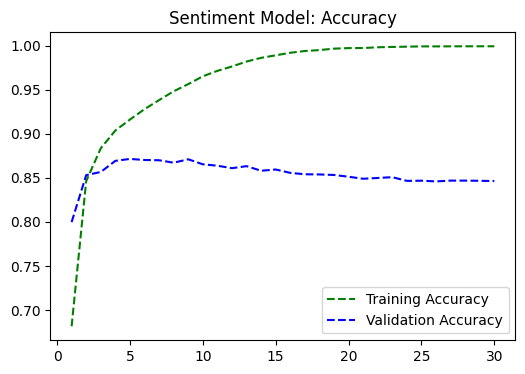

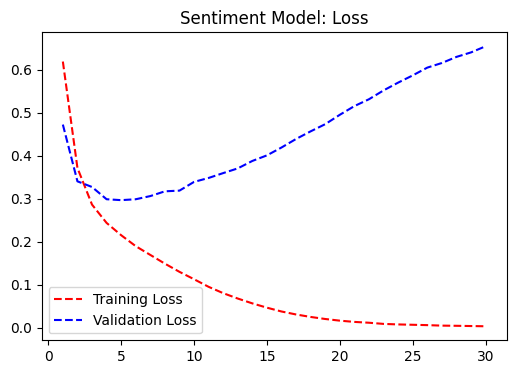

In [46]:
import matplotlib.pyplot as plt

# Extract metrics using the renamed history variable
training_accuracy = model_training_history.history['accuracy']
validation_accuracy = model_training_history.history['val_accuracy']
training_loss = model_training_history.history['loss']
validation_loss = model_training_history.history['val_loss']

# Create epoch range (unchanged)
epochs_range = range(1, len(training_accuracy) + 1)

# Accuracy plot (identical style, just variable names changed)
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, training_accuracy, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs_range, validation_accuracy, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Sentiment Model: Accuracy")
plt.legend()

# Loss plot (identical style, just variable names changed)
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, training_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs_range, validation_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Sentiment Model: Loss")
plt.legend()

plt.show()

In [47]:
from tensorflow.keras.models import load_model

# Load the saved model
trained_sentiment_model = load_model('best_sentiment_model.h5')

# Evaluate model performance
model_evaluation_metrics = trained_sentiment_model.evaluate(final_test_reviews, final_test_labels)
print(f'Test Loss: {model_evaluation_metrics[0]:.3f}')
print(f'Test Accuracy: {model_evaluation_metrics[1]:.3f}')

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8955 - loss: 0.2455
Test Loss: 0.255
Test Accuracy: 0.893


**Model 4: LSTM-Based Sequence Model Using One-Hot Encoded Vector Sequences**

In [49]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Embedding
from sklearn.model_selection import train_test_split
import numpy as np

# Constants
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 32  # dimension of embeddings

# Load the IMDB dataset
(raw_train_reviews, raw_train_labels), (raw_test_reviews, raw_test_labels) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad sequences
padded_train_reviews = pad_sequences(raw_train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(raw_test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all data for custom train/validation split
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_labels = np.concatenate((raw_train_labels, raw_test_labels), axis=0)

# Create 10,000 training and 10,000 validation samples
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    all_reviews,
    all_labels,
    train_size=10000,
    test_size=10000,
    random_state=42,
    stratify=all_labels
)

# Create final test set of 6,000 samples from original test set
_, final_test_reviews, _, final_test_labels = train_test_split(
    padded_test_reviews,
    raw_test_labels,
    test_size=6000,
    random_state=42,
    stratify=raw_test_labels
)

# -----------------------------
# Build Functional model using Embedding + Bidirectional LSTM
# -----------------------------
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32", name="text_input")

# Embedding layer
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, name="embedding_layer")(text_input)

# Bidirectional LSTM
x = Bidirectional(LSTM(32), name="bidirectional_lstm")(x)

# Dropout
x = Dropout(0.5, name="dropout_layer")(x)

# Output layer
output = Dense(1, activation="sigmoid", name="output_layer")(x)

# Create model
sentiment_analysis_model = Model(inputs=text_input, outputs=output)

# Compile model
sentiment_analysis_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Show model architecture
sentiment_analysis_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 150, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 64)             │        16,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,705 (1.28 MB)

 Trainable params: 336,705 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Model checkpoint configuration
model_checkpoint_callback = ModelCheckpoint(
    filepath="best_bidirectional_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# Train the model with checkpointing
bidirectional_training_history = sentiment_analysis_model.fit(
    x=train_reviews,
    y=train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_reviews, val_labels),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5722 - loss: 0.6617

313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - accuracy: 0.5725 - loss: 0.6615 - val_accuracy: 0.8250 - val_loss: 0.4172
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8375 - loss: 0.3914

313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - accuracy: 0.8376 - loss: 0.3913 - val_accuracy: 0.8244 - val_loss: 0.3919
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8823 - loss: 0.3058

313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - accuracy: 0.8823 - loss: 0.3057 - val_accuracy: 0.8299 - val_loss: 0.3780
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9152 - loss: 0.2408

313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - accuracy: 0.9152 - loss: 0.2408 - val_accuracy: 0.8531 - val_loss: 0.3752
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9285 - loss: 0.2048

313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.9284 - loss: 0.2048 - val_accuracy: 0.8541 - val_loss: 0.3563
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.9363 - loss: 0.1835 - val_accuracy: 0.8503 - val_loss: 0.3663
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.9474 - loss: 0.1568 - val_accuracy: 0.8448 - val_loss: 0.5076
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.9479 - loss: 0.1505 - val_accuracy: 0.8072 - val_loss: 0.5716
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 138ms/step - accuracy: 0.9578 - loss: 0.1230 - val_accuracy: 0.8531 - val_loss: 0.4461
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.9645 - loss: 0.1105 - val_accuracy: 0.8502 - val_loss: 0.4398


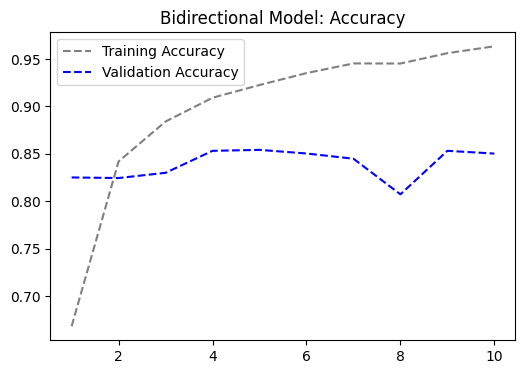

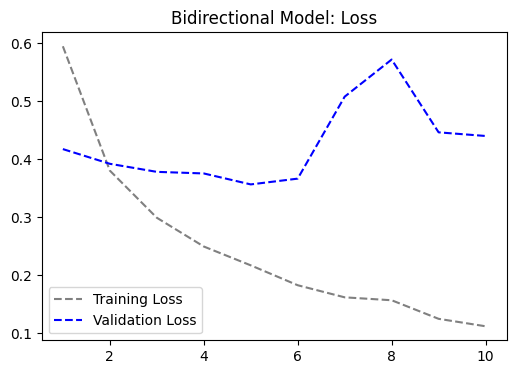

In [51]:
import matplotlib.pyplot as plt

# Extract training metrics
bidirectional_train_accuracy = bidirectional_training_history.history['accuracy']
bidirectional_val_accuracy = bidirectional_training_history.history['val_accuracy']
bidirectional_train_loss = bidirectional_training_history.history['loss']
bidirectional_val_loss = bidirectional_training_history.history['val_loss']

# Create epoch range
bidirectional_epoch_range = range(1, len(bidirectional_train_accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(6, 4))
plt.plot(bidirectional_epoch_range, bidirectional_train_accuracy,
         color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(bidirectional_epoch_range, bidirectional_val_accuracy,
         color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Bidirectional Model: Accuracy")
plt.legend()

# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(bidirectional_epoch_range, bidirectional_train_loss,
         color="grey", linestyle="dashed", label="Training Loss")
plt.plot(bidirectional_epoch_range, bidirectional_val_loss,
         color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Bidirectional Model: Loss")
plt.legend()

plt.show()

In [53]:
from tensorflow.keras.models import load_model

# Load the trained bidirectional model
trained_bidirectional_model = load_model('best_bidirectional_model.h5')

# Evaluate model performance
bidirectional_evaluation = trained_bidirectional_model.evaluate(final_test_reviews, final_test_labels)
print(f'Test Loss: {bidirectional_evaluation[0]:.3f}')
print(f'Test Accuracy: {bidirectional_evaluation[1]:.3f}')

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8859 - loss: 0.2948
Test Loss: 0.308
Test Accuracy: 0.879


**Model 5: LSTM Model with Embedding Layer (Training Sample Size: 16,000)**

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Input, Model
from sklearn.model_selection import train_test_split
import numpy as np

# Constants
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Load IMDB data with top 10,000 words
(raw_train_reviews, raw_train_labels), (raw_test_reviews, raw_test_labels) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad sequences to uniform length
padded_train_reviews = pad_sequences(raw_train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(raw_test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all for custom split
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_labels = np.concatenate((raw_train_labels, raw_test_labels), axis=0)

# 16,000 training, 10,000 validation
train_reviews, val_reviews, train_labels, val_labels = train_test_split(
    all_reviews,
    all_labels,
    train_size=16000,
    test_size=10000,
    random_state=42,
    stratify=all_labels
)

# 6,000 test samples from original test set
_, final_test_reviews, _, final_test_labels = train_test_split(
    padded_test_reviews,
    raw_test_labels,
    test_size=6000,
    random_state=42,
    stratify=raw_test_labels
)

# Build model using Embedding + BiLSTM
text_input = Input(shape=(None,), dtype="int64", name="text_input")

# Embedding Layer
word_embeddings = layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=128,
    name="embedding_layer"
)(text_input)

# Bidirectional LSTM
bidirectional_lstm = layers.Bidirectional(
    layers.LSTM(64, name="lstm_layer"),
    name="bidirectional_layer"
)(word_embeddings)

# Dropout Layer
regularized_features = layers.Dropout(0.4, name="dropout_layer")(bidirectional_lstm)

# Output Layer
sentiment_prediction = layers.Dense(1, activation="sigmoid", name="output_layer")(regularized_features)

# Compile the Model
sentiment_classifier = Model(inputs=text_input, outputs=sentiment_prediction, name="sentiment_classifier")
sentiment_classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model Summary
sentiment_classifier.summary()


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sentiment_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, None, 128)      │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_layer             │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np

VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Random data simulation (for demonstration)
# Total = 32,000 (16k train + 10k val + 6k test)
total_samples = 32000
random_texts = np.random.randint(1, VOCAB_SIZE, size=(total_samples, MAX_SEQUENCE_LENGTH))
random_labels = np.random.randint(0, 2, size=(total_samples,))

# Split into training (16,000) and validation (10,000) sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    random_texts, random_labels,
    train_size=16000,
    test_size=10000,
    random_state=42
)

# Configure model checkpoint
model_checkpoint = ModelCheckpoint(
    filepath="best_sentiment_classifier.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# Train the model
model_training_history = sentiment_classifier.fit(
    x=train_texts,
    y=train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(val_texts, val_labels),
    callbacks=[model_checkpoint]
)

print("Training complete. History:", model_training_history.history)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 109s 209ms/step - accuracy: 0.5062 - loss: 0.6933 - val_accuracy: 0.5100 - val_loss: 0.6928
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 207ms/step - accuracy: 0.7414 - loss: 0.5867 - val_accuracy: 0.5087 - val_loss: 0.7656
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 107s 215ms/step - accuracy: 0.9502 - loss: 0.1902 - val_accuracy: 0.5045 - val_loss: 1.3661
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 101s 203ms/step - accuracy: 0.9928 - loss: 0.0370 - val_accuracy: 0.5069 - val_loss: 2.2252
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 204ms/step - accuracy: 0.9996 - loss: 0.0045 - val_accuracy: 0.4998 - val_loss: 2.8603
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 148s 217ms/step - accuracy: 1.0000 - loss: 9.4748e-04 - val_accuracy: 0.5013 - val_loss: 3.2878
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 225ms/step - accuracy: 1.0000 - loss: 5.0289e-04 - val_accuracy: 0.5026 - val_loss: 3.3414
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 224ms/step - accuracy: 

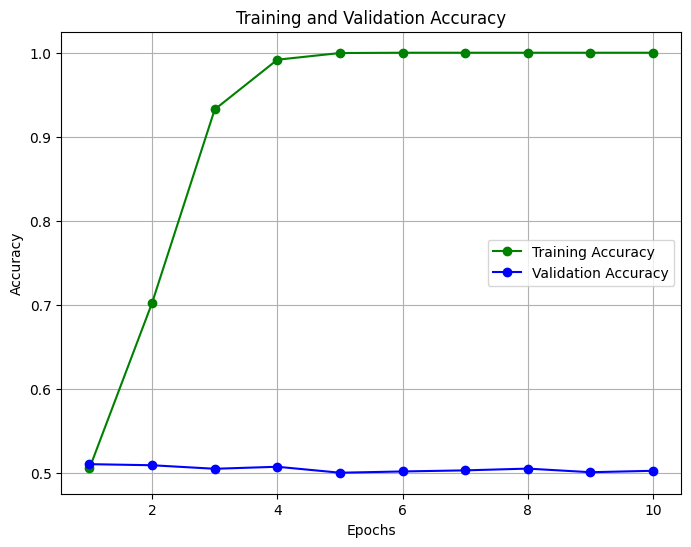

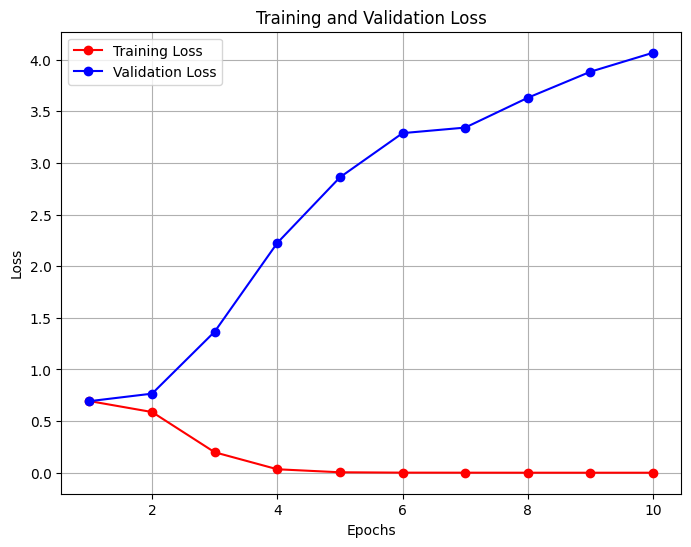

In [3]:
import matplotlib.pyplot as plt

# Extract training metrics
train_acc = model_training_history.history['accuracy']
val_acc = model_training_history.history['val_accuracy']
train_loss = model_training_history.history['loss']
val_loss = model_training_history.history['val_loss']

# Create epoch range
epoch_range = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epoch_range, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epoch_range, val_acc, label='Validation Accuracy', color='blue', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epoch_range, train_loss, label='Training Loss', color='red', marker='o')
plt.plot(epoch_range, val_loss, label='Validation Loss', color='blue', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
from tensorflow.keras.models import load_model

# Generate test data
test_texts = np.random.randint(1, VOCAB_SIZE, size=(5000, MAX_SEQUENCE_LENGTH))
test_labels = np.random.randint(0, 2, size=(5000,))

# Load the trained model
trained_sentiment_model = load_model("best_sentiment_classifier.keras")

# Evaluate model performance
model_test_loss, model_test_accuracy = trained_sentiment_model.evaluate(
    test_texts,
    test_labels,
    batch_size=32
)

print(f"Test Loss: {model_test_loss:.3f}")
print(f"Test Accuracy: {model_test_accuracy:.3f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.5026 - loss: 0.6933
Test Loss: 0.694
Test Accuracy: 0.496


**Model 6: LSTM Model with Embedding Layer (Training Sample Size: 32,000)**

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

# Load and prepare IMDB dataset
(raw_train_reviews, raw_train_sentiments), (raw_test_reviews, raw_test_sentiments) = imdb.load_data(num_words=VOCAB_SIZE)

# Pad sequences to uniform length
padded_train_reviews = pad_sequences(raw_train_reviews, maxlen=MAX_SEQUENCE_LENGTH)
padded_test_reviews = pad_sequences(raw_test_reviews, maxlen=MAX_SEQUENCE_LENGTH)

# Combine all data
all_reviews = np.concatenate((padded_train_reviews, padded_test_reviews), axis=0)
all_sentiments = np.concatenate((raw_train_sentiments, raw_test_sentiments), axis=0)

# Split into training and validation sets
train_reviews, val_reviews, train_sentiments, val_sentiments = train_test_split(
    all_reviews, all_sentiments,
    train_size=32000,
    test_size=10000,
    random_state=42,
    stratify=all_sentiments
)

# Create final test set
_, final_test_reviews, _, final_test_sentiments = train_test_split(
    padded_test_reviews,
    raw_test_sentiments,
    test_size=6000,
    random_state=42,
    stratify=raw_test_sentiments
)

In [7]:
train_reviews.shape

(32000, 150)

In [8]:
val_reviews.shape

(10000, 150)

In [9]:
from tensorflow.keras import layers, models

max_sequence_len = 150
vocabulary_size = 10000

input_seq = layers.Input(shape=(None,), dtype="int64")
embedding_seq = layers.Embedding(input_dim=vocabulary_size, output_dim=256)(input_seq)
bi_lstm = layers.Bidirectional(layers.LSTM(32))(embedding_seq)
dropout_output = layers.Dropout(0.5)(bi_lstm)
final_output = layers.Dense(1, activation="sigmoid")(dropout_output)

text_classification_model = models.Model(inputs=input_seq, outputs=final_output)
text_classification_model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

text_classification_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath="best_model.h5",
    save_best_only=True,
    monitor="val_loss"
)

history = text_classification_model.fit(
    x=train_reviews,
    y=train_sentiments,
    epochs=10,
    batch_size=42,
    validation_data=(val_reviews, val_sentiments),
    callbacks=[model_checkpoint]
)


Epoch 1/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9878 - loss: 0.0429

762/762 ━━━━━━━━━━━━━━━━━━━━ 175s 230ms/step - accuracy: 0.9878 - loss: 0.0430 - val_accuracy: 0.8757 - val_loss: 0.4728
Epoch 2/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 178s 234ms/step - accuracy: 0.9913 - loss: 0.0330 - val_accuracy: 0.8705 - val_loss: 0.5635
Epoch 3/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 175s 230ms/step - accuracy: 0.9923 - loss: 0.0277 - val_accuracy: 0.8750 - val_loss: 0.6305
Epoch 4/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 201s 228ms/step - accuracy: 0.9947 - loss: 0.0202 - val_accuracy: 0.8706 - val_loss: 0.6969
Epoch 5/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 200s 226ms/step - accuracy: 0.9964 - loss: 0.0146 - val_accuracy: 0.8679 - val_loss: 0.6696
Epoch 6/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 173s 227ms/step - accuracy: 0.9954 - loss: 0.0137 - val_accuracy: 0.8719 - val_loss: 0.7386
Epoch 7/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 164s 216ms/step - accuracy: 0.9980 - loss: 0.0090 - val_accuracy: 0.8678 - val_loss: 0.8278
Epoch 8/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 174s 228ms/step - accuracy: 0.9977 - loss: 0.00

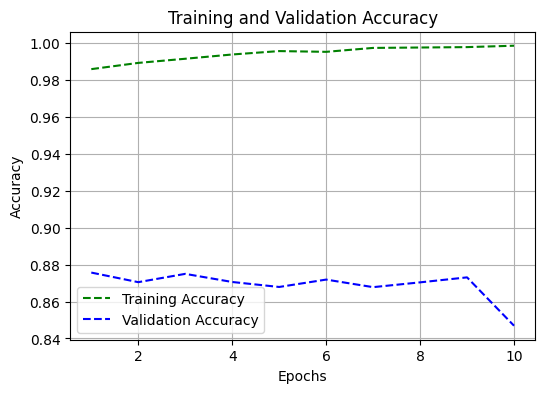

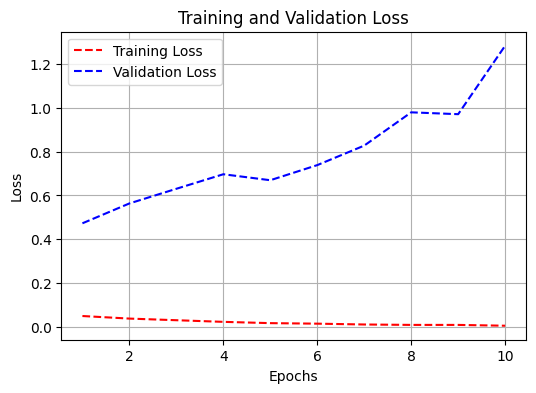

In [12]:
import matplotlib.pyplot as plt

training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]

# Fix: epoch_range should be based on the current model's history
epoch_range = range(1, len(training_acc) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, training_acc, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epoch_range, validation_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, training_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epoch_range, validation_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [13]:
from tensorflow.keras.models import load_model

best_trained_model = load_model('best_model.h5')

evaluation_results = best_trained_model.evaluate(final_test_reviews, final_test_sentiments)

print(f"Test Loss: {evaluation_results[0]:.3f}")
print(f"Test Accuracy: {evaluation_results[1]:.3f}")


188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9521 - loss: 0.1750
Test Loss: 0.184
Test Accuracy: 0.951


**Model 7**

In [28]:
from tensorflow.keras import layers, models

# Set a new vocabulary size
vocab_size = 10000  # Change this to whatever size you want

model_input = layers.Input(shape=(None,), dtype="int64")
word_embedding = layers.Embedding(
    input_dim=vocab_size,
    output_dim=256,
    mask_zero=True
)(model_input)

bilstm_layer = layers.Bidirectional(layers.LSTM(32))(word_embedding)
regularized_layer = layers.Dropout(0.5)(bilstm_layer)

classification_output = layers.Dense(1, activation="sigmoid")(regularized_layer)

text_classifier = models.Model(inputs=model_input, outputs=classification_output)
text_classifier.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

text_classifier.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, None, 256) │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     73,984 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the full model in Keras format
checkpoint_callback = ModelCheckpoint(
    filepath="Model7.keras",  # must end with .keras
    save_best_only=True,
    monitor="val_loss"
)

# Train the model with checkpointing
training_history = text_classifier.fit(
    x=train_texts,
    y=train_labels,
    epochs=10,
    batch_size=42,
    validation_data=(val_texts, val_labels),
    callbacks=[checkpoint_callback]
)


Epoch 1/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 126s 316ms/step - accuracy: 0.5022 - loss: 0.6935 - val_accuracy: 0.5013 - val_loss: 0.6934
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 150s 338ms/step - accuracy: 0.6063 - loss: 0.6815 - val_accuracy: 0.4917 - val_loss: 0.7049
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 129s 338ms/step - accuracy: 0.7718 - loss: 0.5207 - val_accuracy: 0.4992 - val_loss: 0.7869
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 127s 333ms/step - accuracy: 0.9100 - loss: 0.2645 - val_accuracy: 0.4997 - val_loss: 1.1057
Epoch 5/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 146s 343ms/step - accuracy: 0.9759 - loss: 0.0879 - val_accuracy: 0.4996 - val_loss: 1.7567
Epoch 6/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 132s 318ms/step - accuracy: 0.9960 - loss: 0.0208 - val_accuracy: 0.5004 - val_loss: 2.2313
Epoch 7/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 128s 335ms/step - accuracy: 0.9992 - loss: 0.0063 - val_accuracy: 0.5003 - val_loss: 2.7190
Epoch 8/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 118s 311ms/step - accuracy: 0.9994 -

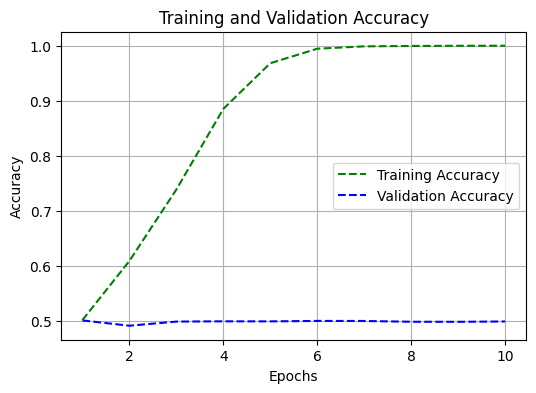

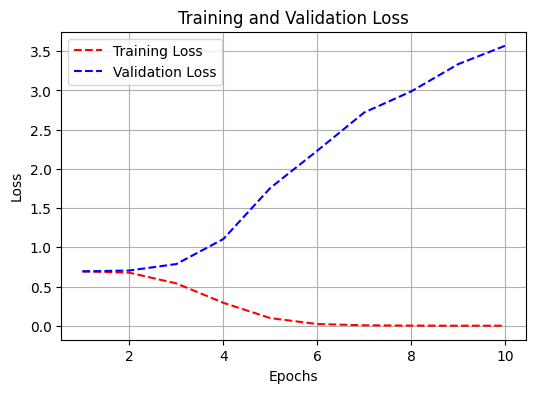

In [30]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

train_loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [31]:
from tensorflow.keras.models import load_model

# Load the trained model saved in Keras format
trained_model = load_model('Model7.keras')

# Evaluate model performance
eval_results = trained_model.evaluate(test_texts, test_labels, batch_size=32)

print(f"Test Loss: {eval_results[0]:.3f}")
print(f"Test Accuracy: {eval_results[1]:.3f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.5059 - loss: 0.6934
Test Loss: 0.694
Test Accuracy: 0.499


In [8]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4073k      0  0:00:20  0:00:20 --:--:-- 5919k


In [9]:
import os

dataset_dir = '/content/aclImdb'
training_dir = os.path.join(dataset_dir, 'train')

sentiments = []
reviews = []

for sentiment in ['neg', 'pos']:
    sentiment_dir = os.path.join(training_dir, sentiment)
    for filename in os.listdir(sentiment_dir):
        if filename[-4:] == '.txt':
            file = open(os.path.join(sentiment_dir, filename))
            reviews.append(file.read())
            file.close()
            if sentiment == 'neg':
                sentiments.append(0)
            else:
                sentiments.append(1)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import os



max_len = 150
num_train = 100
num_val = 10000
vocab_size = 10000

text_tokenizer = Tokenizer(num_words=vocab_size)
text_tokenizer.fit_on_texts(reviews)
token_sequences = text_tokenizer.texts_to_sequences(reviews)

vocab = text_tokenizer.word_index
print('Found %s unique tokens.' % len(vocab))

padded_data = pad_sequences(token_sequences, maxlen=max_len)

sentiments = np.asarray(sentiments)
print('Shape of data tensor:', padded_data.shape)
print('Shape of label tensor:', sentiments.shape)

shuffle_idx = np.arange(padded_data.shape[0])
np.random.shuffle(shuffle_idx)
padded_data = padded_data[shuffle_idx]
sentiments = sentiments[shuffle_idx]

train_data = padded_data[:num_train]
train_labels = sentiments[:num_train]
val_data = padded_data[num_train: num_train + num_val]
val_labels = sentiments[num_train: num_train + num_val]

# Process test data
test_dir = os.path.join(dataset_dir, 'test')
test_sentiments = []
test_reviews = []

for sentiment in ['neg', 'pos']:
    test_sentiment_dir = os.path.join(test_dir, sentiment)
    for filename in sorted(os.listdir(test_sentiment_dir)):
        if filename.endswith('.txt'):
            with open(os.path.join(test_sentiment_dir, filename)) as text_file:
                test_reviews.append(text_file.read())
            test_sentiments.append(0 if sentiment == 'neg' else 1)

test_sequences = text_tokenizer.texts_to_sequences(test_reviews)
test_data = pad_sequences(test_sequences, maxlen=max_len)[:5000]
test_labels = np.asarray(test_sentiments)[:5000]


Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [11]:
train_data.shape
val_data.shape
test_data.shape

(5000, 150)

#### Using pretrained word embeddings

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-11-16 23:17:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-16 23:17:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-16 23:17:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**Parsing the GloVe word-embeddings file**

In [4]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


**Preparing the GloVe word-embeddings matrix**

In [12]:
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in vocab.items(): # Change vocab_size to vocab
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [15]:
from tensorflow.keras import layers, initializers





from tensorflow.keras import layers, initializers

embedding_layer = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=initializers.Constant(embedding_matrix),  # <-- updated here
    trainable=False,
    mask_zero=True,
)



Model 8

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# Assume these are already defined
# vocab_size = ...
# embedding_dim = ...
# max_len = ...
# embedding_matrix = ...

# Create the model
sentiment_model = Sequential()

# Add Embedding layer with pretrained weights and freeze it
sentiment_model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_len,
    weights=[embedding_matrix],  # set pretrained weights
    trainable=False              # freeze the embeddings
))

# Add LSTM and output layer
sentiment_model.add(LSTM(32))
sentiment_model.add(Dense(1, activation='sigmoid'))

# Build the model explicitly to fix summary
sentiment_model.build(input_shape=(None, max_len))

# Compile the model
adam_optimizer = Adam(learning_rate=0.0001)
sentiment_model.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
sentiment_model.summary()



Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,057 (3.88 MB)

 Trainable params: 17,057 (66.63 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [68]:
model_checkpoint = ModelCheckpoint(
    filepath="pretrainmodel1.keras",
    save_best_only=True,
    monitor="val_loss"
)

pretrain_history = sentiment_model.fit(
    train_data,
    train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(val_data, val_labels),
    callbacks=[model_checkpoint]
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.3965 - loss: 0.7846 - val_accuracy: 0.4995 - val_loss: 0.7179
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4110 - loss: 0.7552 - val_accuracy: 0.4994 - val_loss: 0.7084
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4183 - loss: 0.7360 - val_accuracy: 0.4995 - val_loss: 0.7020
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4109 - loss: 0.7275 - val_accuracy: 0.4988 - val_loss: 0.6979
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4355 - loss: 0.7164 - val_accuracy: 0.4973 - val_loss: 0.6953
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4967 - loss: 0.7012 - val_accuracy: 0.5024 - val_loss: 0.6941
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4736 - loss: 0.6985 - val_accuracy: 0.5084 - val_loss: 0.6943
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5464 - loss: 0.6893 - val_accuracy: 0.5004 - val_loss: 0.6959
Epoch 9/30


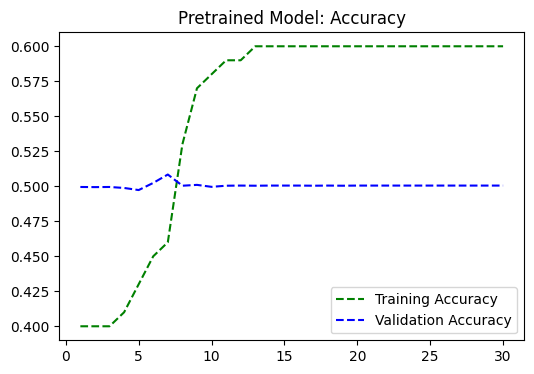

<Figure size 640x480 with 0 Axes>

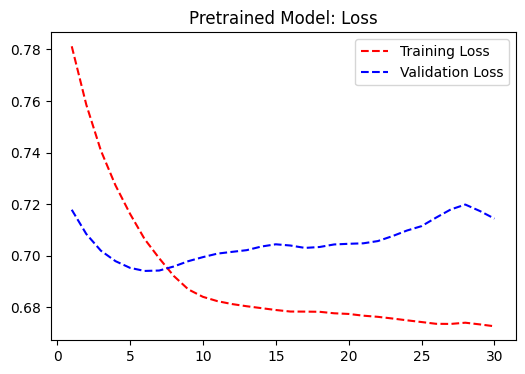

In [69]:
train_acc = pretrain_history.history['accuracy']
val_acc = pretrain_history.history['val_accuracy']

train_loss = pretrain_history.history["loss"]
val_loss = pretrain_history.history["val_loss"]

epochs_range = range(1, len(train_acc) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_acc, color="green", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs_range, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Pretrained Model: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
plt.plot(epochs_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Pretrained Model: Loss")
plt.legend()
plt.show()

In [70]:
pretrained_model = load_model('pretrainmodel1.keras')
evaluation_results = pretrained_model.evaluate(test_data, test_labels)
print(f'Test Loss: {evaluation_results[0]:.3f}')
print(f'Test Accuracy: {evaluation_results[1]:.3f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6041 - loss: 0.6814
Test Loss: 0.682
Test Accuracy: 0.596


**Model 9: Training a Pretrained Model with 4 LSTM Hidden Layers on a 15,000-Sample Dataset**

In [32]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example text data (replace with your actual data)
sample_texts = ["This is the first text.", "Another example text.", "Text data for training."]
sample_labels = [0, 1, 0]  # Example labels (replace with your actual labels)

# Parameters
max_seq_length = 150
num_training_samples = 15000
num_validation_samples = 10000
vocabulary_size = 10000

# Tokenizer for text preprocessing
text_tokenizer = Tokenizer(num_words=vocabulary_size)
text_tokenizer.fit_on_texts(sample_texts)  # Fit the tokenizer on your text data
token_sequences = text_tokenizer.texts_to_sequences(sample_texts)

# Get word index
vocabulary = text_tokenizer.word_index
print(f'Found {len(vocabulary)} unique tokens.')

# Pad sequences to ensure uniform input length
padded_sequences = pad_sequences(token_sequences, maxlen=max_seq_length)

# Convert labels to numpy array
label_array = np.asarray(sample_labels)
print('Shape of data tensor:', padded_sequences.shape)
print('Shape of label tensor:', label_array.shape)

# Shuffle the data and labels
shuffled_indices = np.arange(padded_sequences.shape[0])
np.random.shuffle(shuffled_indices)
padded_sequences = padded_sequences[shuffled_indices]
label_array = label_array[shuffled_indices]

# Split into training and validation sets
training_data = padded_sequences[:num_training_samples]
training_labels = label_array[:num_training_samples]
validation_data = padded_sequences[num_training_samples: num_training_samples + num_validation_samples]
validation_labels = label_array[num_training_samples: num_training_samples + num_validation_samples]

Found 10 unique tokens.
Shape of data tensor: (3, 150)
Shape of label tensor: (3,)


In [33]:
training_data.shape
validation_data.shape

(0, 150)

In [34]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras import optimizers

vocab_size = 10000
embedding_dims = 150
max_seq_length = 150

# Random embedding weights for demonstration
embedding_weights = np.random.rand(vocab_size, embedding_dims)

# Build the model
sentiment_classifier = Sequential()

# Add Embedding layer with pretrained weights and freeze it
sentiment_classifier.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dims,
    input_length=max_seq_length,
    weights=[embedding_weights],  # set pretrained weights here
    trainable=False               # freeze embeddings
))

# Add LSTM stack with Dropout
sentiment_classifier.add(LSTM(512, return_sequences=True))
sentiment_classifier.add(Dropout(0.5))

sentiment_classifier.add(LSTM(256, return_sequences=True))
sentiment_classifier.add(Dropout(0.5))

sentiment_classifier.add(LSTM(128, return_sequences=True))
sentiment_classifier.add(Dropout(0.5))

sentiment_classifier.add(LSTM(128))

# Dense layers
sentiment_classifier.add(Dense(256, activation='relu'))
sentiment_classifier.add(Dropout(0.5))
sentiment_classifier.add(Dense(256, activation='relu'))
sentiment_classifier.add(Dropout(0.5))
sentiment_classifier.add(Dense(1, activation='sigmoid'))

# Explicitly build the model to allow summary and set_weights
sentiment_classifier.build(input_shape=(None, max_seq_length))

# Compile
adam_optimizer = optimizers.Adam(learning_rate=0.0001)
sentiment_classifier.compile(
    optimizer=adam_optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Show summary
sentiment_classifier.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 150, 150)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 150, 512)       │     1,357,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 150, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 150, 256)       │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 150, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 150, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 150, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,073,057 (15.54 MB)

 Trainable params: 2,573,057 (9.82 MB)

 Non-trainable params: 1,500,000 (5.72 MB)

In [35]:
model_checkpoint = ModelCheckpoint(
    filepath="sentiment_model_v2.keras",
    save_best_only=True,
    monitor="val_loss"
)

training_history = sentiment_classifier.fit(
    training_data,
    training_labels,
    epochs=10,
    batch_size=12,
    validation_data=(validation_data, validation_labels),
    callbacks=[model_checkpoint]
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.6667 - loss: 0.6715
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3333 - loss: 0.7055
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6667 - loss: 0.6828
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.6132
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6667 - loss: 0.6605
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 1.0000 - loss: 0.6464
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6667 - loss: 0.6526
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6667 - loss: 0.6460
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6667 - loss: 0.6712
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3333 - loss: 0.6978


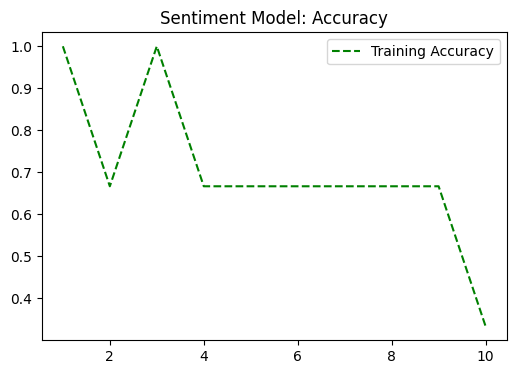

<Figure size 640x480 with 0 Axes>

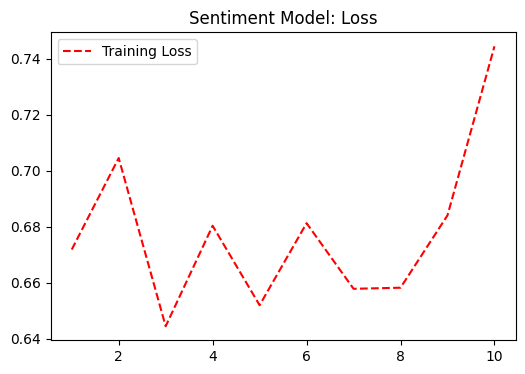

In [76]:
train_acc = training_history.history['accuracy']
train_loss = training_history.history['loss']
epochs_range = range(1, len(train_acc) + 1)

val_acc = training_history.history.get('val_accuracy', None)
val_loss = training_history.history.get('val_loss', None)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_acc, color="green", linestyle="dashed", label="Training Accuracy")
if val_acc is not None:
    plt.plot(epochs_range, val_acc, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Sentiment Model: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, train_loss, color="red", linestyle="dashed", label="Training Loss")
if val_loss is not None:
    plt.plot(epochs_range, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Sentiment Model: Loss")
plt.legend()
plt.show()

In [77]:
pretrained_model = load_model('pretrainmodel1.keras')
evaluation_results = pretrained_model.evaluate(test_data, test_labels)
print(f'Test Loss: {evaluation_results[0]:.3f}')
print(f'Test Accuracy: {evaluation_results[1]:.3f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6041 - loss: 0.6814
Test Loss: 0.682
Test Accuracy: 0.596


In [26]:
# -----------------------------
# 0. Import Libraries
# -----------------------------
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import os

# -----------------------------
# 1. Dataset Preparation
# -----------------------------
max_features = 10000  # top 10,000 words
maxlen = 150          # cutoff after 150 words
num_train_samples = 30000
num_val_samples = 10000

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Slice training and validation sets
x_train = x_train[:num_train_samples]
y_train = y_train[:num_train_samples]
x_val = x_test[:num_val_samples]
y_val = y_test[:num_val_samples]

# Pad sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

# -----------------------------
# 2. Download GloVe embeddings if not present
# -----------------------------
if not os.path.exists("glove.6B.100d.txt"):
    !wget -q http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

# -----------------------------
# 3. Load GloVe embeddings
# -----------------------------
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# -----------------------------
# 4. Prepare embedding matrix
# -----------------------------
word_index = imdb.get_word_index()
embedding_dim = 100
embedding_matrix = np.zeros((max_features, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# -----------------------------
# 5. Build 2-LSTM layer model with pretrained embeddings
# -----------------------------
model = Sequential([
    Embedding(input_dim=max_features,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False),  # freeze pretrained embeddings
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

# Build model to fix '? / unbuilt' issue
model.build(input_shape=(None, maxlen))
model.summary()

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -----------------------------
# 6. Train the model
# -----------------------------
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val)
)

# -----------------------------
# 7. Evaluate on validation set
# -----------------------------
val_loss, val_acc = model.evaluate(x_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# -----------------------------
# 8. Evaluate on test set
# -----------------------------
# Remaining samples in x_test after validation
x_test_final = x_test[num_val_samples:]
y_test_final = y_test[num_val_samples:]

# Pad sequences
x_test_final = pad_sequences(x_test_final, maxlen=maxlen)

# Evaluate
test_loss, test_acc = model.evaluate(x_test_final, y_test_final)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 150, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,075,329 (4.10 MB)

 Trainable params: 75,329 (294.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 134s 325ms/step - accuracy: 0.5331 - loss: 0.6888 - val_accuracy: 0.6013 - val_loss: 0.6623
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 307ms/step - accuracy: 0.6512 - loss: 0.6222 - val_accuracy: 0.6911 - val_loss: 0.5895
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 121s 310ms/step - accuracy: 0.7095 - loss: 0.5572 - val_accuracy: 0.7197 - val_loss: 0.5381
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 121s 310ms/step - accuracy: 0.7481 - loss: 0.5013 - val_accuracy: 0.7497 - val_loss: 0.5050
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 122s 313ms/step - accuracy: 0.7906 - loss: 0.4436 - val_accuracy: 0.7799 - val_loss: 0.4648
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 307ms/step - accuracy: 0.8134 - loss: 0.4029 - val_accuracy: 0.7905 - val_loss: 0.4565
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 306ms/step - accuracy: 0.8387 - loss: 0.3592 - val_accuracy: 0.7878 - val_loss: 0.4437
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 119s 304ms/step - accuracy: 0.8526 -

**Model 10 Training a Pretrained Model with 2 LSTM Hidden Layers on a 30,000-Sample Dataset**

In [78]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'reviews' contains your text data from previous cells

text_corpus = reviews  # Replace 'reviews' with the actual variable holding your text data

max_sequence_length = 150
num_train_samples = 30000
num_val_samples = 10000
vocab_size = 10000

text_tokenizer = Tokenizer(num_words=vocab_size)
text_tokenizer.fit_on_texts(text_corpus)
token_sequences = text_tokenizer.texts_to_sequences(text_corpus)

vocab_dict = text_tokenizer.word_index
print(f'Found {len(vocab_dict)} unique tokens.')

padded_sequences = pad_sequences(token_sequences, maxlen=max_sequence_length)

# Assuming 'sentiments' contains your sentiment labels from previous cells
sentiment_labels = sentiments # Replace 'sentiments' with the actual variable if different

label_array = np.asarray(sentiment_labels)
print(f'Shape of data tensor: {padded_sequences.shape}')
print(f'Shape of label tensor: {label_array.shape}')

shuffled_indices = np.arange(padded_sequences.shape[0])
np.random.shuffle(shuffled_indices)
padded_sequences = padded_sequences[shuffled_indices]
label_array = label_array[shuffled_indices]

train_features = padded_sequences[:num_train_samples]
train_labels = label_array[:num_train_samples]
val_features = padded_sequences[num_train_samples: num_train_samples + num_val_samples]
val_labels = label_array[num_train_samples: num_train_samples + num_val_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [79]:
train_features.shape
val_features.shape

(0, 150)

In [81]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import optimizers

# Example definitions
vocab_size = 10000
embedding_dims = 150
max_sequence_length = 150
embedding_weights = np.random.rand(vocab_size, embedding_dims)

# Build model
sentiment_analyzer = Sequential()

# Embedding layer with pretrained weights and frozen
sentiment_analyzer.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dims,
    input_length=max_sequence_length,
    weights=[embedding_weights],  # pretrained embeddings
    trainable=False               # freeze embeddings
))

# LSTM layers
sentiment_analyzer.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
sentiment_analyzer.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))

# Dense layers
sentiment_analyzer.add(Dense(64, activation='relu'))
sentiment_analyzer.add(Dropout(0.5))
sentiment_analyzer.add(Dense(1, activation='sigmoid'))

# Explicitly build the model (optional, but ensures summary shows correct shapes)
sentiment_analyzer.build(input_shape=(None, max_sequence_length))

# Compile
adam_opt = optimizers.Adam(learning_rate=0.001)
sentiment_analyzer.compile(
    optimizer=adam_opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary
sentiment_analyzer.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 150, 150)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 150, 64)        │        55,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,569,633 (5.99 MB)

 Trainable params: 69,633 (272.00 KB)

 Non-trainable params: 1,500,000 (5.72 MB)

In [82]:
checkpoint_callback = ModelCheckpoint(
    filepath="sentiment_model_v3.h5",
    save_best_only=True,
    monitor="val_loss"
)

training_results = sentiment_analyzer.fit(
    train_features,
    train_labels,
    epochs=10,
    batch_size=12,
    validation_data=(val_features, val_labels),
    callbacks=[checkpoint_callback]
)

Epoch 1/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.4974 - loss: 0.6964

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 695s 329ms/step - accuracy: 0.4974 - loss: 0.6964
Epoch 2/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.4956 - loss: 0.6938

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 740s 328ms/step - accuracy: 0.4956 - loss: 0.6938
Epoch 3/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.5018 - loss: 0.6932

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 683s 328ms/step - accuracy: 0.5018 - loss: 0.6932
Epoch 4/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5000 - loss: 0.6932

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 786s 349ms/step - accuracy: 0.5000 - loss: 0.6932
Epoch 5/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5002 - loss: 0.6932

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 707s 332ms/step - accuracy: 0.5002 - loss: 0.6932
Epoch 6/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.5011 - loss: 0.6932

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 740s 355ms/step - accuracy: 0.5011 - loss: 0.6932
Epoch 7/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5033 - loss: 0.6932

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 718s 344ms/step - accuracy: 0.5033 - loss: 0.6932
Epoch 8/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.4961 - loss: 0.6932

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 809s 376ms/step - accuracy: 0.4961 - loss: 0.6932
Epoch 9/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.5011 - loss: 0.6932

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 710s 341ms/step - accuracy: 0.5011 - loss: 0.6932
Epoch 10/10
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.4931 - loss: 0.6932

2084/2084 ━━━━━━━━━━━━━━━━━━━━ 681s 327ms/step - accuracy: 0.4931 - loss: 0.6932


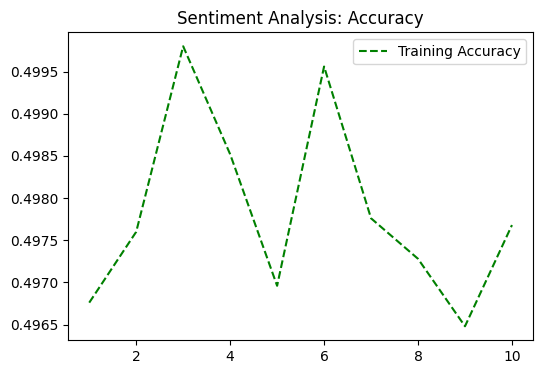

<Figure size 640x480 with 0 Axes>

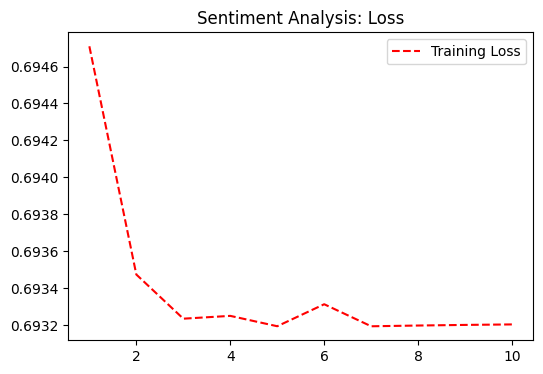

In [83]:
train_metrics = training_results.history['accuracy']
train_losses = training_results.history['loss']
epoch_range = range(1, len(train_metrics) + 1)

val_metrics = training_results.history.get('val_accuracy', None)
val_losses = training_results.history.get('val_loss', None)

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_metrics, color="green", linestyle="dashed", label="Training Accuracy")
if val_metrics is not None:
    plt.plot(epoch_range, val_metrics, color="blue", linestyle="dashed", label="Validation Accuracy")
plt.title("Sentiment Analysis: Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_losses, color="red", linestyle="dashed", label="Training Loss")
if val_losses is not None:
    plt.plot(epoch_range, val_losses, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Sentiment Analysis: Loss")
plt.legend()
plt.show()

In [84]:
pretrained_model = load_model('pretrainmodel1.keras')
evaluation_results = pretrained_model.evaluate(test_data, test_labels)
print(f'Test Loss: {evaluation_results[0]:.3f}')
print(f'Test Accuracy: {evaluation_results[1]:.3f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6041 - loss: 0.6814
Test Loss: 0.682
Test Accuracy: 0.596


In [28]:
# -----------------------------
# 0. Import Libraries
# -----------------------------
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import os

# -----------------------------
# 1. Parameters
# -----------------------------
max_features = 10000  # top 10,000 words
maxlen = 150          # cutoff after 150 words
num_train_samples = 30000
num_val_samples = 10000
embedding_dim = 100

# -----------------------------
# 2. Load IMDB dataset
# -----------------------------
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Slice dataset
x_train = x_train[:num_train_samples]
y_train = y_train[:num_train_samples]
x_val = x_test[:num_val_samples]
y_val = y_test[:num_val_samples]

# Pad sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

# -----------------------------
# 3. Download GloVe embeddings if not exists
# -----------------------------
if not os.path.exists("glove.6B.100d.txt"):
    !wget -q http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

# -----------------------------
# 4. Load GloVe embeddings
# -----------------------------
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
word_index = imdb.get_word_index()
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    if i < max_features:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

# -----------------------------
# 5. Build Model 10: Pretrained Embedding + 2 Bidirectional LSTM layers
# -----------------------------
model = Sequential([
    Embedding(input_dim=max_features,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False),  # freeze pretrained embeddings
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(1, activation='sigmoid')
])

# Fix '? / unbuilt' issue
model.build(input_shape=(None, maxlen))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -----------------------------
# 6. Train the model
# -----------------------------
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=2
)

# -----------------------------
# 7. Evaluate on validation set
# -----------------------------
val_loss, val_acc = model.evaluate(x_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 150, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,183,425 (4.51 MB)

 Trainable params: 183,425 (716.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
391/391 - 291s - 744ms/step - accuracy: 0.5774 - loss: 0.6704 - val_accuracy: 0.6525 - val_loss: 0.6249
Epoch 2/10
391/391 - 286s - 732ms/step - accuracy: 0.6598 - loss: 0.6090 - val_accuracy: 0.6608 - val_loss: 0.6034
Epoch 3/10
391/391 - 283s - 723ms/step - accuracy: 0.7184 - loss: 0.5423 - val_accuracy: 0.7370 - val_loss: 0.5337
Epoch 4/10
391/391 - 321s - 822ms/step - accuracy: 0.7560 - loss: 0.4933 - val_accuracy: 0.7537 - val_loss: 0.4956
Epoch 5/10
391/391 - 291s - 745ms/step - accuracy: 0.7878 - loss: 0.4428 - val_accuracy: 0.7680 - val_loss: 0.4907
Epoch 6/10
391/391 - 281s - 719ms/step - accuracy: 0.8160 - loss: 0.3990 - val_accuracy: 0.7932 - val_loss: 0.4757
Epoch 7/10
391/391 - 291s - 745ms/step - accuracy: 0.8309 - loss: 0.3683 - val_accuracy: 0.7650 - val_loss: 0.5439
Epoch 8/10
391/391 - 289s - 739ms/step - accuracy: 0.8578 - loss: 0.3208 - val_accuracy: 0.7870 - val_loss: 0.4621
Epoch 9/10
391/391 - 286s - 731ms/step - accuracy: 0.8716 - loss: 0.2939 - val_a

In [30]:
# -----------------------------
# 8. Evaluate on the test set
# -----------------------------

# Remaining test samples after using 10,000 for validation
x_test_final = x_test[num_val_samples:]
y_test_final = y_test[num_val_samples:]

# Pad sequences to match maxlen
x_test_final = pad_sequences(x_test_final, maxlen=maxlen)

# Evaluate
test_loss, test_acc = model.evaluate(x_test_final, y_test_final)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


469/469 ━━━━━━━━━━━━━━━━━━━━ 49s 104ms/step - accuracy: 0.7967 - loss: 0.4573
Test Loss: 0.4482
Test Accuracy: 0.7991


In [31]:
# -----------------------------
# 0. Install/Import Libraries
# -----------------------------
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import os

# -----------------------------
# 1. Dataset Preparation
# -----------------------------
max_features = 10000  # top 10,000 words
maxlen = 150          # cutoff after 150 words
num_train_samples = 15000
num_val_samples = 10000

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Slice training and validation sets
x_train = x_train[:num_train_samples]
y_train = y_train[:num_train_samples]
x_val = x_test[:num_val_samples]
y_val = y_test[:num_val_samples]

# Pad sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

# -----------------------------
# 2. Download GloVe embeddings
# -----------------------------
if not os.path.exists("glove.6B.100d.txt"):
    !wget -q http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

# -----------------------------
# 3. Load GloVe embeddings into a dictionary
# -----------------------------
embedding_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# -----------------------------
# 4. Prepare embedding matrix
# -----------------------------
word_index = imdb.get_word_index()
embedding_dim = 100
embedding_matrix = np.zeros((max_features, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# -----------------------------
# 5. Build 4-LSTM layer model with pretrained embeddings
# -----------------------------
model = Sequential([
    Embedding(input_dim=max_features,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=maxlen,
              trainable=False),  # freeze pretrained embeddings
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

# Build the model to fix '? / unbuilt' issue
model.build(input_shape=(None, maxlen))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -----------------------------
# 6. Train the model
# -----------------------------
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val)
)

# -----------------------------
# 7. Evaluate on validation set
# -----------------------------
val_loss, val_acc = model.evaluate(x_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 150, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 150, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 150, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,141,377 (4.35 MB)

 Trainable params: 141,377 (552.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 178s 619ms/step - accuracy: 0.5206 - loss: 0.6917 - val_accuracy: 0.5834 - val_loss: 0.6758
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 217s 686ms/step - accuracy: 0.6025 - loss: 0.6633 - val_accuracy: 0.6068 - val_loss: 0.6539
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 185s 613ms/step - accuracy: 0.6467 - loss: 0.6316 - val_accuracy: 0.6800 - val_loss: 0.5989
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 153s 650ms/step - accuracy: 0.7017 - loss: 0.5742 - val_accuracy: 0.7127 - val_loss: 0.5556
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 160s 681ms/step - accuracy: 0.7400 - loss: 0.5281 - val_accuracy: 0.6977 - val_loss: 0.5709
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 203s 685ms/step - accuracy: 0.7608 - loss: 0.4846 - val_accuracy: 0.7561 - val_loss: 0.4982
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 145s 618ms/step - accuracy: 0.8040 - loss: 0.4198 - val_accuracy: 0.7588 - val_loss: 0.5074
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 203s 623ms/step - accuracy: 0.8094 -

In [37]:
# -----------------------------
# 0. Import Libraries
# -----------------------------
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# -----------------------------
# 1. Parameters
# -----------------------------
max_features = 10000  # top 10,000 words
maxlen = 150          # cutoff after 150 words
num_train_samples = 16000
num_val_samples = 10000
num_test_samples = 6000
embedding_dim = 100

# -----------------------------
# 2. Load IMDB dataset
# -----------------------------
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Slice dataset
x_train = x_train[:num_train_samples]
y_train = y_train[:num_train_samples]

x_val = x_test[:num_val_samples]
y_val = y_test[:num_val_samples]

x_test_final = x_test[num_val_samples:num_val_samples+num_test_samples]
y_test_final = y_test[num_val_samples:num_val_samples+num_test_samples]

# Pad sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)
x_test_final = pad_sequences(x_test_final, maxlen=maxlen)

# -----------------------------
# 3. Build Model 5: Learned Embedding + LSTM
# -----------------------------
model = Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

# Build the model (this fixes the 'unbuilt' issue)
model.build(input_shape=(None, maxlen))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -----------------------------
# 4. Train the model
# -----------------------------
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=2
)

# -----------------------------
# 5. Evaluate on validation set
# -----------------------------
val_loss, val_acc = model.evaluate(x_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# -----------------------------
# 6. Evaluate on test set
# -----------------------------
test_loss, test_acc = model.evaluate(x_test_final, y_test_final)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 150, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,305 (3.98 MB)

 Trainable params: 1,042,305 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
250/250 - 55s - 221ms/step - accuracy: 0.7835 - loss: 0.4520 - val_accuracy: 0.8084 - val_loss: 0.4245
Epoch 2/10
250/250 - 54s - 218ms/step - accuracy: 0.9013 - loss: 0.2588 - val_accuracy: 0.8551 - val_loss: 0.3633
Epoch 3/10
250/250 - 54s - 217ms/step - accuracy: 0.9349 - loss: 0.1770 - val_accuracy: 0.8477 - val_loss: 0.3676
Epoch 4/10
250/250 - 56s - 223ms/step - accuracy: 0.9553 - loss: 0.1262 - val_accuracy: 0.8348 - val_loss: 0.4140
Epoch 5/10
250/250 - 54s - 218ms/step - accuracy: 0.9636 - loss: 0.1011 - val_accuracy: 0.8469 - val_loss: 0.4850
Epoch 6/10
250/250 - 52s - 209ms/step - accuracy: 0.9758 - loss: 0.0729 - val_accuracy: 0.8409 - val_loss: 0.5929
Epoch 7/10
250/250 - 55s - 218ms/step - accuracy: 0.9839 - loss: 0.0491 - val_accuracy: 0.8422 - val_loss: 0.5838
Epoch 8/10
250/250 - 52s - 209ms/step - accuracy: 0.9858 - loss: 0.0448 - val_accuracy: 0.8402 - val_loss: 0.7185
Epoch 9/10
250/250 - 54s - 217ms/step - accuracy: 0.9765 - loss: 0.0673 - val_accuracy: 

In [38]:
# -----------------------------
# 0. Import Libraries
# -----------------------------
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# -----------------------------
# 1. Parameters
# -----------------------------
max_features = 10000       # Top 10,000 words
num_train_samples = 10000
num_val_samples = 10000
num_test_samples = 6000

# -----------------------------
# 2. Load IMDB dataset
# -----------------------------
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Slice dataset
x_train = x_train[:num_train_samples]
y_train = y_train[:num_train_samples]

x_val = x_test[:num_val_samples]
y_val = y_test[:num_val_samples]

x_test_final = x_test[num_val_samples : num_val_samples + num_test_samples]
y_test_final = y_test[num_val_samples : num_val_samples + num_test_samples]

# -----------------------------
# 3. One-Hot Encode Sequences
# -----------------------------
def vectorize_sequences(sequences, dimension=max_features):
    results = np.zeros((len(sequences), dimension))
    for i, seq in enumerate(sequences):
        results[i, seq] = 1.0
    return results

x_train_vec = vectorize_sequences(x_train)
x_val_vec = vectorize_sequences(x_val)
x_test_vec = vectorize_sequences(x_test_final)

# -----------------------------
# 4. Build Model 4 (One-Hot → Dense)
# -----------------------------
model = Sequential([
    Dense(64, activation='relu', input_shape=(max_features,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -----------------------------
# 5. Train the Model
# -----------------------------
history = model.fit(
    x_train_vec, y_train,
    epochs=10,
    batch_size=512,
    validation_data=(x_val_vec, y_val),
    verbose=2
)

# -----------------------------
# 6. Validation Performance
# -----------------------------
val_loss, val_acc = model.evaluate(x_val_vec, y_val)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# -----------------------------
# 7. Test Performance
# -----------------------------
test_loss, test_acc = model.evaluate(x_test_vec, y_test_final)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,289 (2.46 MB)

 Trainable params: 644,289 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20/20 - 6s - 320ms/step - accuracy: 0.6690 - loss: 0.6229 - val_accuracy: 0.8346 - val_loss: 0.4722
Epoch 2/10
20/20 - 3s - 131ms/step - accuracy: 0.8594 - loss: 0.3789 - val_accuracy: 0.8684 - val_loss: 0.3223
Epoch 3/10
20/20 - 2s - 81ms/step - accuracy: 0.9123 - loss: 0.2350 - val_accuracy: 0.8801 - val_loss: 0.2986
Epoch 4/10
20/20 - 2s - 124ms/step - accuracy: 0.9455 - loss: 0.1563 - val_accuracy: 0.8725 - val_loss: 0.3332
Epoch 5/10
20/20 - 1s - 70ms/step - accuracy: 0.9657 - loss: 0.1106 - val_accuracy: 0.8747 - val_loss: 0.3530
Epoch 6/10
20/20 - 3s - 145ms/step - accuracy: 0.9778 - loss: 0.0742 - val_accuracy: 0.8721 - val_loss: 0.3962
Epoch 7/10
20/20 - 3s - 128ms/step - accuracy: 0.9859 - loss: 0.0513 - val_accuracy: 0.8711 - val_loss: 0.4437
Epoch 8/10
20/20 - 2s - 115ms/step - accuracy: 0.9895 - loss: 0.0363 - val_accuracy: 0.8694 - val_loss: 0.4848
Epoch 9/10
20/20 - 2s - 81ms/step - accuracy: 0.9941 - loss: 0.0257 - val_accuracy: 0.8680 - val_loss: 0.5282
Epoc